# Multiple objective land allocation (MOLA)

This notebook present an example of a MOLA analysis using python. We set up the problem as a linear programming optimization problem and solve it. This example is based on material from Sam Ratick at Clark University.

In [345]:
############### SESYNC Research Support: Urban green planning ########## 
## Testing optimization.
## 
##
## DATE CREATED: 11/15/2018
## DATE MODIFIED: 12/11/2018
## AUTHORS: Benoit Parmentier  
## Version: 1
## PROJECT: Urban green infrastructure planning
## ISSUE: 
## TO DO:
##
## COMMIT: fixed gdal.Warp bug, reprojection to MD SRS
##

###################################################
#

###### Library used

import gdal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import scipy
from math import cos
import cvxpy

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script 
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

############################################################################
#####  Parameters and argument set up ########### 

#ARGS 1
in_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/Data"
#in_dir <- "/nfs/tjovanovic-data/Data/Baltimore/Hydrology/GAstart"
#ARGS 2
out_dir = "/nfs/bparmentier-data/Data/projects/urban_green_planning/outputs"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 7
out_suffix = "mola_example_12032018" #output suffix for the files and ouptut folder
#ARGS 8
num_cores = 2 # number of cores
file_format = ".tif"

#dem_baltimore_filename = "DEM_BaltArea_1m.tif"
#lc_baltimore_filename = "landCover_area1m.tif"
#reg_outline_filename = "watersheds8digit.shp"

################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    #out_path<-"/data/project/layers/commons/data_workflow/output_data"
    out_dir = "output_data_"+out_suffix
    out_dir = os.path.join(in_dir,out_dir)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier

directory already exists


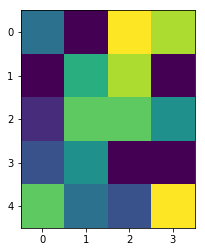

In [346]:
#######################################
### PART 1: Read in DATA #######

# Let's create a factor (attribute) in the multiobjective land allocation:

r_d = np.arange(25).reshape((5, 5))         # create a 1-d range and reshape
plt.imshow (r_d)

f2 = [3,0,8,7,
     0,5,7,0,
     1,6,6,4,
    2,4,0,0,
    6,3,2,8]
f2 = np.asarray(f2)

r_d = f2.reshape((5,4))         # distance to road
plt.imshow (r_d)



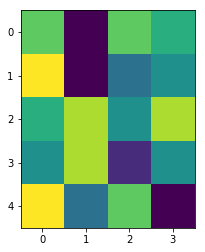

In [347]:
### Now generate second factor: Map slope

f2 = [6,0,6,5,
     8,0,3,4,
     5,7,4,7,
     4,7,1,4,
     8,3,6,0]
f2 = np.asarray(f2)

r_s = f2.reshape((5,4))         # slope map
plt.imshow (r_s)


#### Problem set up

Assume that you are land planner and you are tasked with selecting areas for the development of as ski resort whil setting aside land for Habitat protection. The steps are as follow:

1. Create factor maps (variables/criteria) relevant for your land use type objective.
2. Select, obtain or generate weights to combine your factor (e.g. AHP, SMART etc.)
3. Generate a suitability map for your land objective that combines all factors



[[15  0 30 26]
 [ 8 15 24  4]
 [ 8 25 22 19]
 [10 19  1  4]
 [26 12 12 24]]


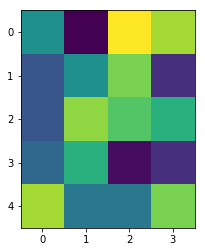

In [348]:
# Generate Habitat suitability 

r_suitability_habitat = 3*r_d + 1 * r_s 
print(r_suitability_habitat)
plt.imshow (r_suitability_habitat)
# note cell [1,1] is 15= 3*3 + 1*6

[[15  0 20 17]
 [16  5 13  8]
 [11 20 14 18]
 [10 18  2  8]
 [22  9 14  8]]


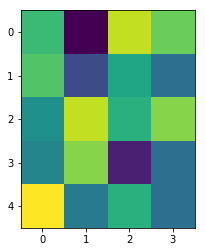

In [349]:
# Generate Ski resort suitability 

r_suitability_ski = 1*r_d +2*r_s 
#r_suitability_ski = np.add(1*r_d,2*r_s)

print(r_suitability_ski)
plt.imshow(r_suitability_ski)
# note cell [1,1] is 17= 1*5 + 2*6

[[17  8 12 11]
 [24  3  7 16]
 [17 16 10 18]
 [14 18 10 16]
 [18 11 18  0]]


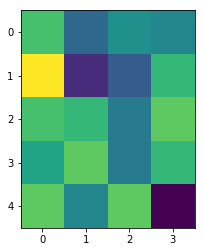

In [350]:
# Generate Ski resort suitability 

f1_ski = [5,8,0,1,
          8,3,1,8,
          7,2,2,4,
          6,4,8,8,
          2,5,6,0]

f2_ski = [6,0,6,5,
          8,0,3,4,
          5,7,4,7,
          4,7,1,4,
          8,3,6,0]

f1_ski = np.asarray(f1_ski)
f2_ski = np.asarray(f2_ski)

r_ski_s = f2_ski.reshape((5,4))         # slope map
plt.imshow (r_ski_s)
r_ski_d = f1_ski.reshape((5,4))         # distance map
plt.imshow (r_ski_d)

r_suitability_ski = 1*r_ski_d +2*r_ski_s 
#r_suitability_ski = np.add(1*r_d,2*r_s)

print(r_suitability_ski)
plt.imshow(r_suitability_ski)
# note cell [1,1] is 17= 1*5 + 2*6

In [351]:
from pulp import *
import numpy as np

number_of_objectives = 2
number_of_locations = 20
#n_pix = number_of_objectives*number_of_locations
n_pix = 20

pixels=['pixel_%d'%i for i in range(n_pix)] # for spatial application: locations,parcels or pixels to select 
#variables. How many of each object to take. For simplicity lets make this 0 or 1 (classic 0-1 knapsack problem)
#x1 = LpVariable.dicts('pixel',pixels,0,1, LpBinary) #decision var for ski objective
#x2 = LpVariable.dicts('pixel',pixels,0,1, LpBinary) #decision for habitat objection
x = LpVariable.dicts('pixel',pixels,0,1, LpBinary) #decision for habitat objection

r_suitability_combined = r_suitability_ski + r_suitability_habitat

#val1 = dict(zip(pixels,r_suitability_ski.ravel().T))
val = dict(zip(pixels,r_suitability_combined.ravel().T))
            
D = 10 #select 10 locations/pixels for ski, correspond to Weight in Knapsack 0-1

#create the problme
prob=LpProblem("knapsack",LpMaximize)


In [352]:
list_obj= [val[i]*x[i] for i in pixels]

#cost1 = lpSum([ val1[i]*x1[i] for i in pixels]) # suitability sum ojb1
#cost2 = lpSum([ val2[i]*x2[i] for i in pixels]) # suitability sum ojb2

cost = lpSum(list_obj)
#prob+=cost
#prob+=cost1
#prob+=cost2
prob+=cost

#Demand constraint
#pixel_weights = np.ones(20)
pixel_weights = dict(zip(pixels,np.ones(20).T))
#val1 = dict(zip(pixels,r_suitability_ski.ravel().T))

#list_constraint1 = [pixel_weights[i]*x1[i] for i in pixels]
#list_constraint2 = [pixel_weights[i]*x2[i] for i in pixels]
print(pixel_weights)

{'pixel_18': 1.0, 'pixel_14': 1.0, 'pixel_6': 1.0, 'pixel_5': 1.0, 'pixel_9': 1.0, 'pixel_0': 1.0, 'pixel_11': 1.0, 'pixel_8': 1.0, 'pixel_13': 1.0, 'pixel_12': 1.0, 'pixel_16': 1.0, 'pixel_19': 1.0, 'pixel_7': 1.0, 'pixel_17': 1.0, 'pixel_3': 1.0, 'pixel_15': 1.0, 'pixel_10': 1.0, 'pixel_2': 1.0, 'pixel_4': 1.0, 'pixel_1': 1.0}


In [353]:
list_constraint = [pixel_weights[i]*x1[i] for i in pixels]
prob += lpSum(list_constraint) <= D #demand for ski resort

print(prob)

%time prob.solve()
print(LpStatus[prob.status])

#for i in items:
#    print(i, value(x[i]))
    

knapsack:
MAXIMIZE
32*pixel_pixel_0 + 8*pixel_pixel_1 + 32*pixel_pixel_10 + 37*pixel_pixel_11 + 24*pixel_pixel_12 + 37*pixel_pixel_13 + 11*pixel_pixel_14 + 20*pixel_pixel_15 + 44*pixel_pixel_16 + 23*pixel_pixel_17 + 30*pixel_pixel_18 + 24*pixel_pixel_19 + 42*pixel_pixel_2 + 37*pixel_pixel_3 + 32*pixel_pixel_4 + 18*pixel_pixel_5 + 31*pixel_pixel_6 + 20*pixel_pixel_7 + 25*pixel_pixel_8 + 41*pixel_pixel_9 + 0
SUBJECT TO
_C1: pixel_pixel_0 + pixel_pixel_1 + pixel_pixel_10 + pixel_pixel_11
 + pixel_pixel_12 + pixel_pixel_13 + pixel_pixel_14 + pixel_pixel_15
 + pixel_pixel_16 + pixel_pixel_17 + pixel_pixel_18 + pixel_pixel_19
 + pixel_pixel_2 + pixel_pixel_3 + pixel_pixel_4 + pixel_pixel_5
 + pixel_pixel_6 + pixel_pixel_7 + pixel_pixel_8 + pixel_pixel_9 <= 10

VARIABLES
0 <= pixel_pixel_0 <= 1 Integer
0 <= pixel_pixel_0 <= 1 Integer
0 <= pixel_pixel_1 <= 1 Integer
0 <= pixel_pixel_1 <= 1 Integer
0 <= pixel_pixel_10 <= 1 Integer
0 <= pixel_pixel_10 <= 1 Integer
0 <= pixel_pixel_11 <= 1 Intege

PulpSolverError: Pulp: Error while executing /research-home/bparmentier/.local/lib/python3.5/site-packages/pulp/solverdir/cbc/linux/64/cbc

Not Solved


In [354]:
in_filename_data = "Vacant_distanceTemperature.csv"

data_df = pd.read_csv(os.path.join(in_dir,in_filename_data))
print(data_df.size,
      data_df.shape)

data_df.head()


8725 (1745, 5)


,FID,OBJECTID,BLOCKLOT,DISTANCE,TEMPERATURE
0,0,666179,3438B002B,0.018812,0.582045
1,1,666200,1158 080,0.010489,0.554612
2,2,666208,3804 017,0.014795,0.532371
3,3,666212,4114C029,0.013429,0.590748
4,4,666224,1144 004,0.010189,0.508618


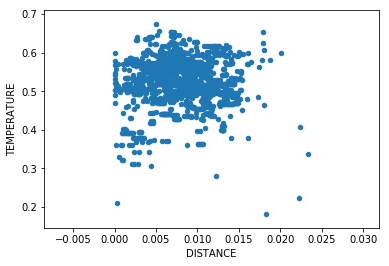

In [355]:
data_df.plot.scatter(x='DISTANCE',y='TEMPERATURE')

In [356]:
f_combined = data_df['DISTANCE'] + data_df['TEMPERATURE']
type(f_combined)
f_combined.head()

0    0.600857
1    0.565101
2    0.547166
3    0.604177
4    0.518807
dtype: float64

In [357]:
factor_combined=f_combined.as_matrix()
type(factor_combined)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


numpy.ndarray

In [358]:
from pulp import *
import numpy as np

number_of_objectives = 2
number_of_locations = 1745
#n_pix = number_of_objectives*number_of_locations
n_loc = 1745

locations=['location_%d'%i for i in range(n_loc)] # for spatial application: locations,parcels or pixels to select 

#variables. How many of each object to take. For simplicity lets make this 0 or 1 (classic 0-1 knapsack problem)
#x1 = LpVariable.dicts('pixel',pixels,0,1, LpBinary) #decision var for ski objective
#x2 = LpVariable.dicts('pixel',pixels,0,1, LpBinary) #decision for habitat objection
x = LpVariable.dicts('location',locations,0,1, LpBinary) #decision for habitat objection

#val1 = dict(zip(pixels,r_suitability_ski.ravel().T))
val = dict(zip(locations,factor_combined))
            
D=200 
#select 200 locations correspond to Weight in Knapsack 0-1

#create the problme
prob2=LpProblem("knapsack",LpMaximize)


In [359]:
list_obj= [val[i]*x[i] for i in locations]

#cost1 = lpSum([ val1[i]*x1[i] for i in pixels]) # suitability sum ojb1
#cost2 = lpSum([ val2[i]*x2[i] for i in pixels]) # suitability sum ojb2

cost = lpSum(list_obj)
#prob+=cost
#prob+=cost1
#prob+=cost2
prob2+=cost

#Demand constraint
#pixel_weights = np.ones(20)
location_weights = dict(zip(locations,np.ones(n_loc).T))
#val1 = dict(zip(pixels,r_suitability_ski.ravel().T))

#list_constraint1 = [pixel_weights[i]*x1[i] for i in pixels]
#list_constraint2 = [pixel_weights[i]*x2[i] for i in pixels]
#print(location_weights[1])

In [360]:
list_constraint = [location_weights[i]*x[i] for i in locations]
prob2 += lpSum(list_constraint) <= D #demand for ski resort

#print(prob2)

%time prob2.solve()
print(LpStatus[prob2.status])


CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 135 ms
Optimal


In [361]:

bool_val = []
for i in locations:
    tmp_val =value(x[i])
    #print(i, value(x[i]))
    bool_val.append(tmp_val)

data_df['f_combined'] = f_combined
data_df['selection']=bool_val

data_df.head()

,FID,OBJECTID,BLOCKLOT,DISTANCE,TEMPERATURE,f_combined,selection
0,0,666179,3438B002B,0.018812,0.582045,0.600857,1.0
1,1,666200,1158 080,0.010489,0.554612,0.565101,0.0
2,2,666208,3804 017,0.014795,0.532371,0.547166,0.0
3,3,666212,4114C029,0.013429,0.590748,0.604177,1.0
4,4,666224,1144 004,0.010189,0.508618,0.518807,0.0


In [362]:
sum(bool_val) #Ok sum is matching the demand

200.0

AttributeError: Unknown property z

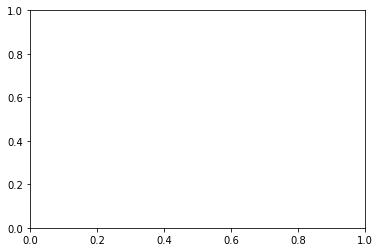

In [363]:
data_df.plot.scatter(x='DISTANCE',y='TEMPERATURE',z='f_combined')